# LSTM model
Pure ERCOT load LSTM

### prediction frame
with n = 6 and m = 4
features:
t-n to t+m-1 of load ERCOT
labels:
t to t+m-1 of load ERCOT

In [2]:
import sys
 
# setting path
sys.path.append('../../../data')
from data import *

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,  Flatten

import matplotlib.pyplot as plt

from statistics import mean, stdev
import pandas as pd
import numpy as np
import datetime

In [4]:
start = datetime.datetime.now()

In [5]:
past_hours = 6
n_steps = past_hours
next_hours = 4
next_steps = next_hours

In [6]:
transformations = [("y",StandardScaler(copy=True), make_column_selector(pattern = 'ERCOT'))]
ct = ColumnTransformer(transformations)

normed_data = pd.DataFrame(ct.fit_transform(load_data))
normed_data

,0
0,-0.861036
1,-0.727637
2,-0.782265
3,-0.941622
4,-1.188049
...,...
94909,0.436792
94910,0.269458
94911,0.129600
94912,-0.005014


In [7]:
dataset = normed_data.values
steps = n_steps+next_steps
time_series =  np.array([dataset[i:i + steps].copy() for i in range(len(dataset) - steps) if load_data.index[i+steps] - load_data.index[i] == datetime.timedelta(hours=steps)])

time_series.shape

(94378, 10, 1)

In [8]:
X = time_series[:, :n_steps, :]
Y = time_series[:, n_steps:, -1]

print(X.shape, Y.shape)

(94378, 6, 1) (94378, 4)


In [9]:
#sizes for test, train, and validation datasets
a = len(time_series)
b = int(0.9*a)
c = int(a-b)//2

In [10]:
X_train,    Y_train =   X[:b],      Y[:b]
X_val,      Y_val   =   X[b:b+c],   Y[b:b+c]
X_test,     Y_test  =   X[b+c:],    Y[b+c:]

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(84940, 6, 1) (4719, 6, 1) (4719, 6, 1)
(84940, 4) (4719, 4) (4719, 4)


In [11]:
model = Sequential([
    Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    Dense(256, activation="sigmoid"),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(next_steps)
])

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [13]:
EPOCHS = 30

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1)

Epoch 1/30
2655/2655 [==============================] - 7s 2ms/step - loss: 0.1968 - mae: 0.3355 - mse: 0.1968 - val_loss: 0.2001 - val_mae: 0.3329 - val_mse: 0.2001
Epoch 2/30
2655/2655 [==============================] - 6s 2ms/step - loss: 0.0961 - mae: 0.2381 - mse: 0.0961 - val_loss: 0.1706 - val_mae: 0.3073 - val_mse: 0.1706
Epoch 3/30
2655/2655 [==============================] - 6s 2ms/step - loss: 0.0837 - mae: 0.2213 - mse: 0.0837 - val_loss: 0.1387 - val_mae: 0.2791 - val_mse: 0.1387
Epoch 4/30
2655/2655 [==============================] - 6s 2ms/step - loss: 0.0753 - mae: 0.2090 - mse: 0.0753 - val_loss: 0.1249 - val_mae: 0.2554 - val_mse: 0.1249
Epoch 5/30
2655/2655 [==============================] - 6s 2ms/step - loss: 0.0686 - mae: 0.1990 - mse: 0.0686 - val_loss: 0.1117 - val_mae: 0.2471 - val_mse: 0.1117
Epoch 6/30
2655/2655 [==============================] - 6s 2ms/step - loss: 0.0649 - mae: 0.1928 - mse: 0.0649 - val_loss: 0.1075 - val_mae: 0.2423 - val_mse: 0.1075
Epoc

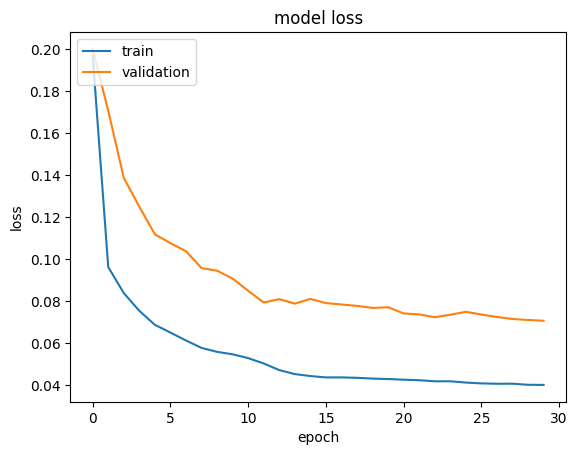

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
test_predictions = model.predict(X_test)
op_list= [e for y in test_predictions for e in y]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list
print(len(op_list), len(ip_list))

148/148 [==============================] - 0s 873us/step
18876 18876


In [16]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -1347.1015845559507
Mean of absolute error in test data: 2361.9347735840156
Root of mean of squared error in test data: 3309.8164854445868
Standard deviation of error in test data: 3023.3568656951584
MPE (%): -1.9491143789833112
MAPE (%): 4.6443206384845075
RMSPE (%): 6.039988913417981
Deviation of error (%): 5.717005398873721
Mean of test data: 47586.94378734902
Standard deviation of test data: 10122.94285891266
Coefficient of determination: 0.8930902615422733


In [17]:
#absolute errors
for threshold in [5,10,50,100,500,1000,1500,2000,3000,4000,5000]:
    accuracy = sum(abs(e) < threshold for e in error)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 0.169527442254715 % with threshold of 5
accuracy: 0.3337571519389701 % with threshold of 10
accuracy: 1.6793812248357705 % with threshold of 50
accuracy: 3.4329307056579785 % with threshold of 100
accuracy: 16.772621318075863 % with threshold of 500
accuracy: 32.930705657978386 % with threshold of 1000
accuracy: 47.39881330790422 % with threshold of 1500
accuracy: 58.6670904852723 % with threshold of 2000
accuracy: 73.25174825174825 % with threshold of 3000
accuracy: 81.93473193473193 % with threshold of 4000
accuracy: 87.52913752913753 % with threshold of 5000


In [18]:
#relative errors
for threshold in [0.5,1,1.5,2,3,4,5]:
    accuracy = sum(abs(e) < threshold for e in rerror)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 7.506887052341598 % with threshold of 0.5
accuracy: 14.83894892985802 % with threshold of 1
accuracy: 21.90082644628099 % with threshold of 1.5
accuracy: 29.047467683831318 % with threshold of 2
accuracy: 41.66666666666667 % with threshold of 3
accuracy: 53.13625768171223 % with threshold of 4
accuracy: 63.47743165924984 % with threshold of 5


In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 48})

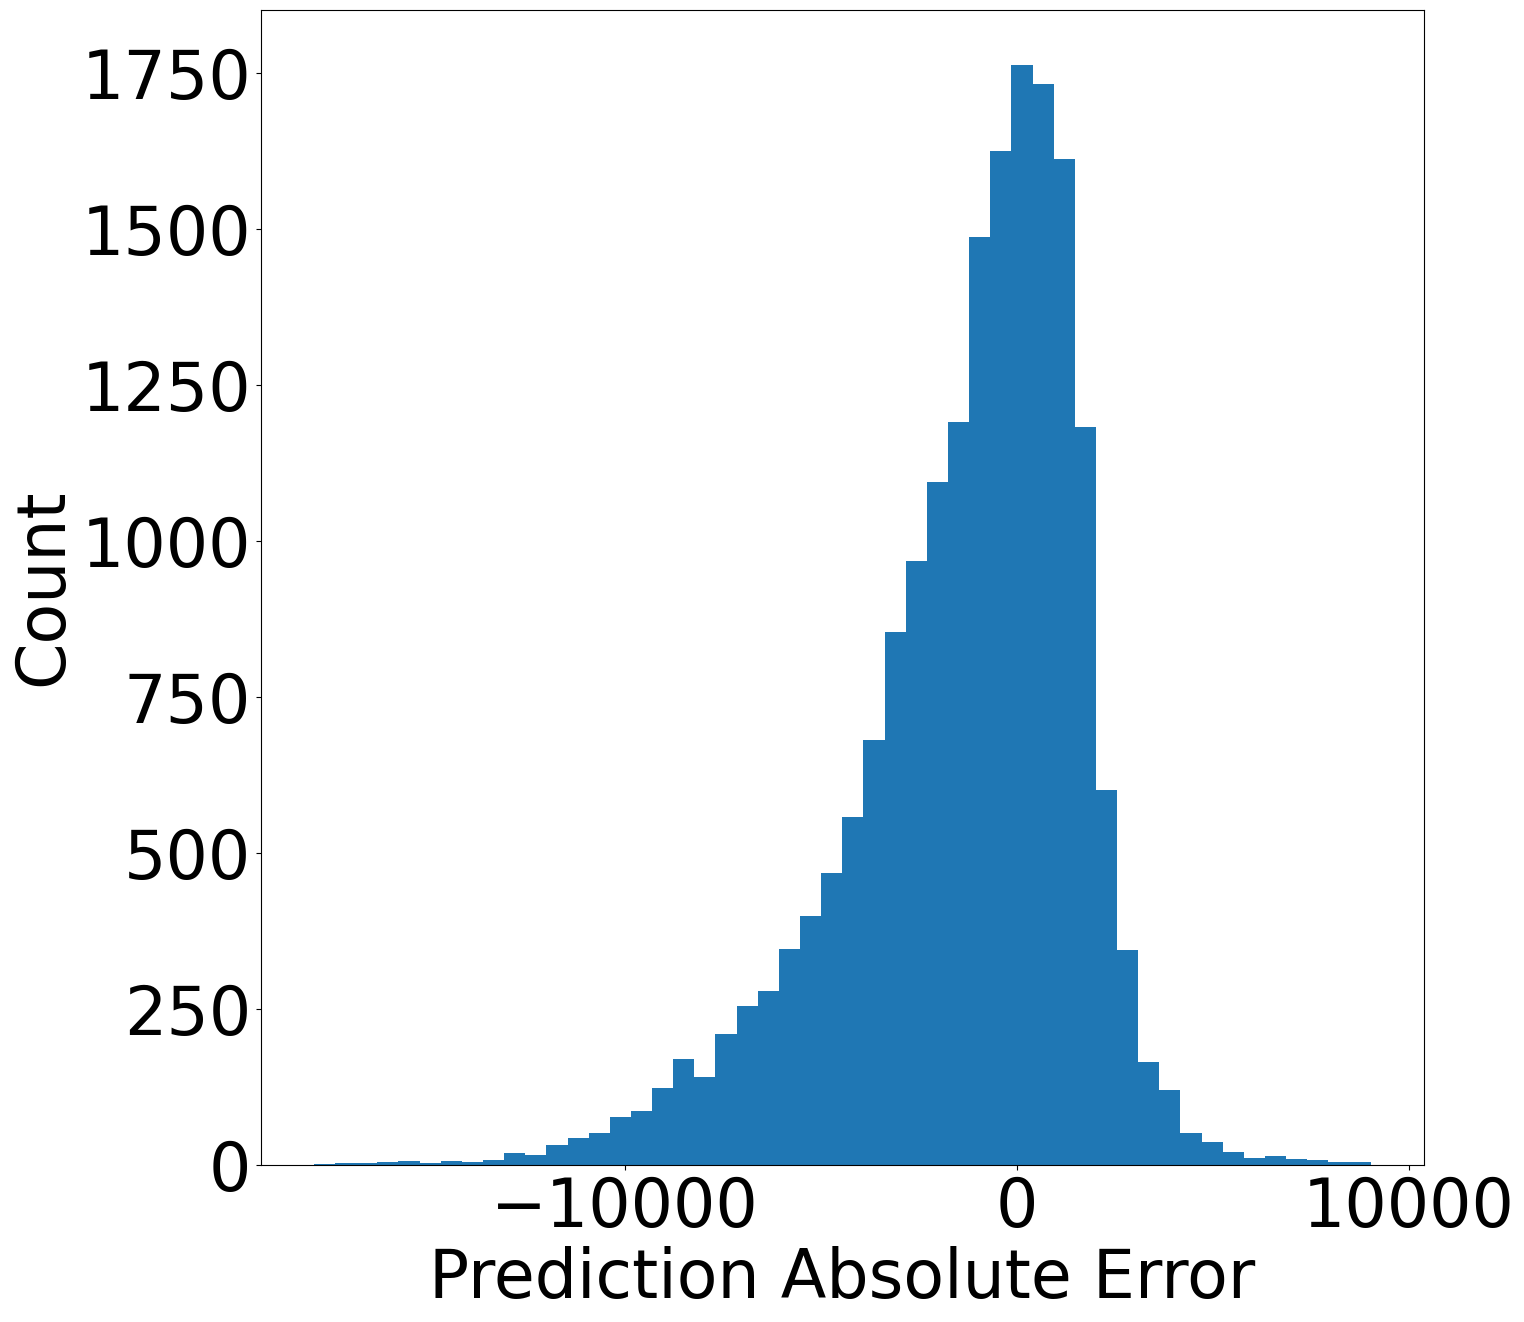

In [20]:
plt.figure(figsize=(15,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Absolute Error")
_ = plt.ylabel("Count")

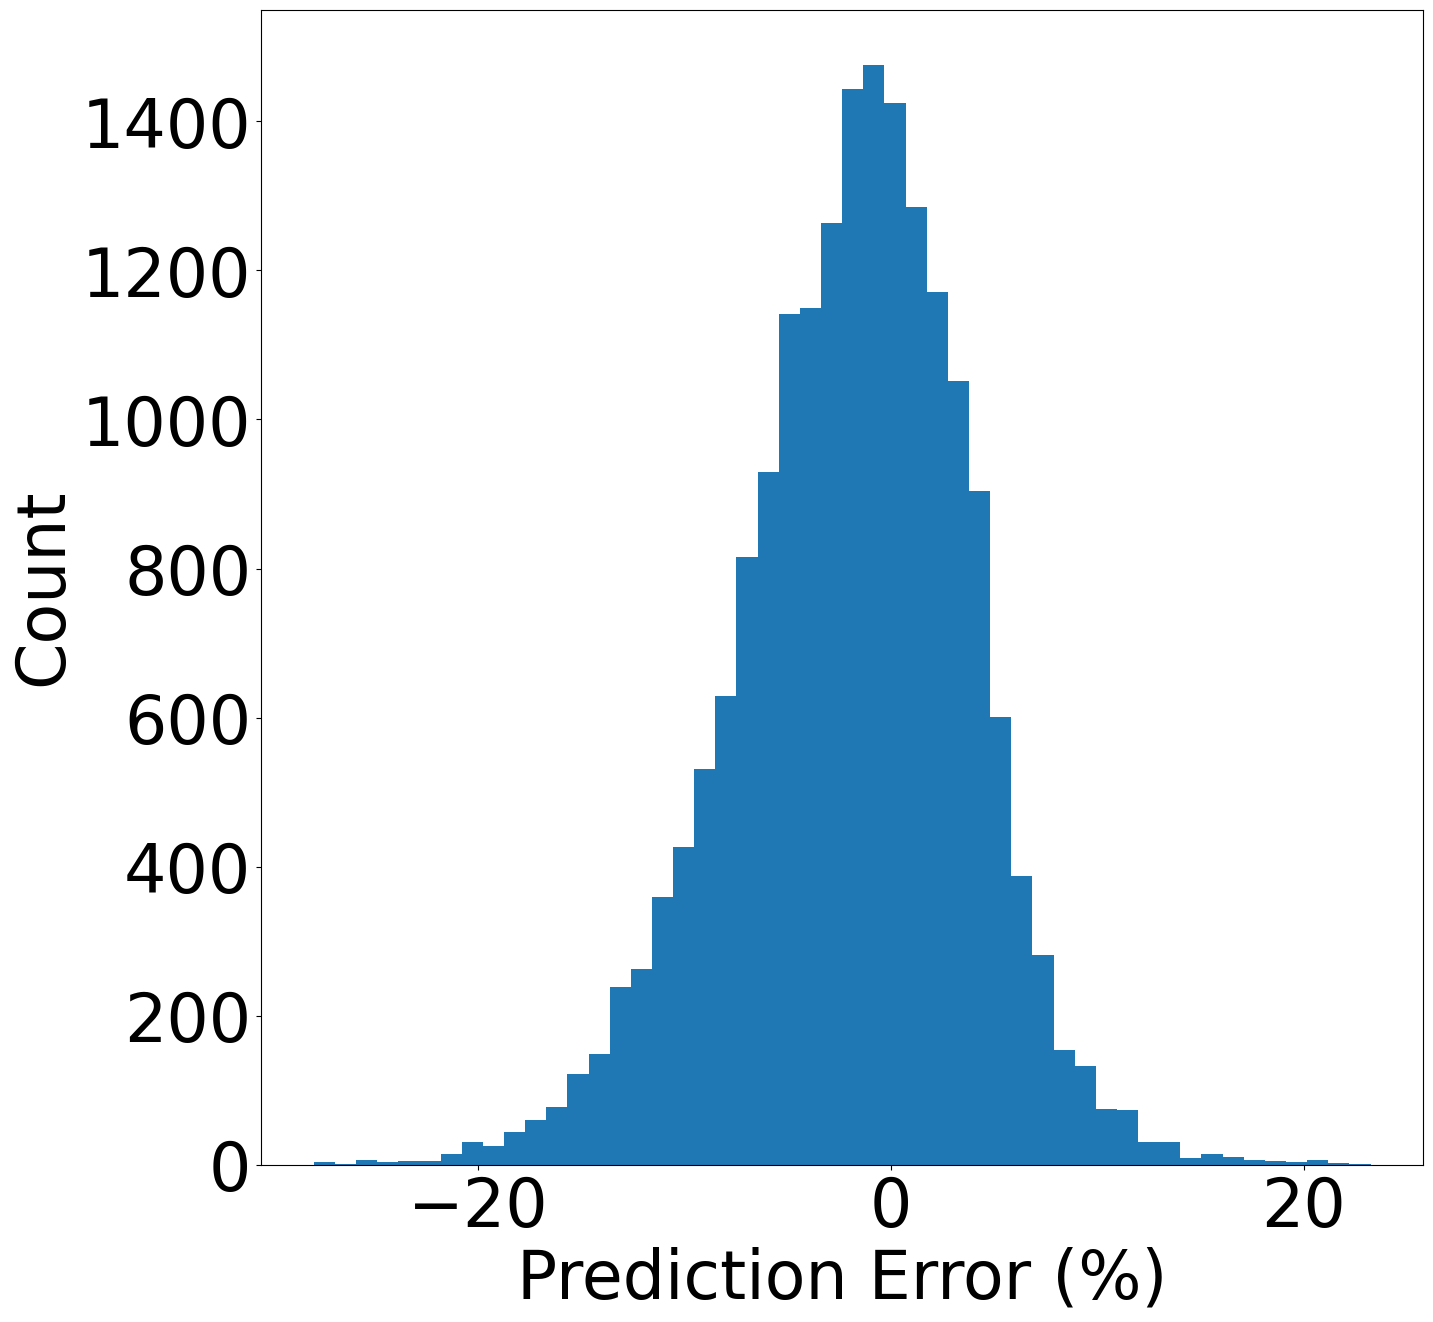

In [21]:
plt.figure(figsize=(15,15))
plt.hist(rerror, bins = 50)
plt.xlabel("Prediction Error (%)")
_ = plt.ylabel("Count")

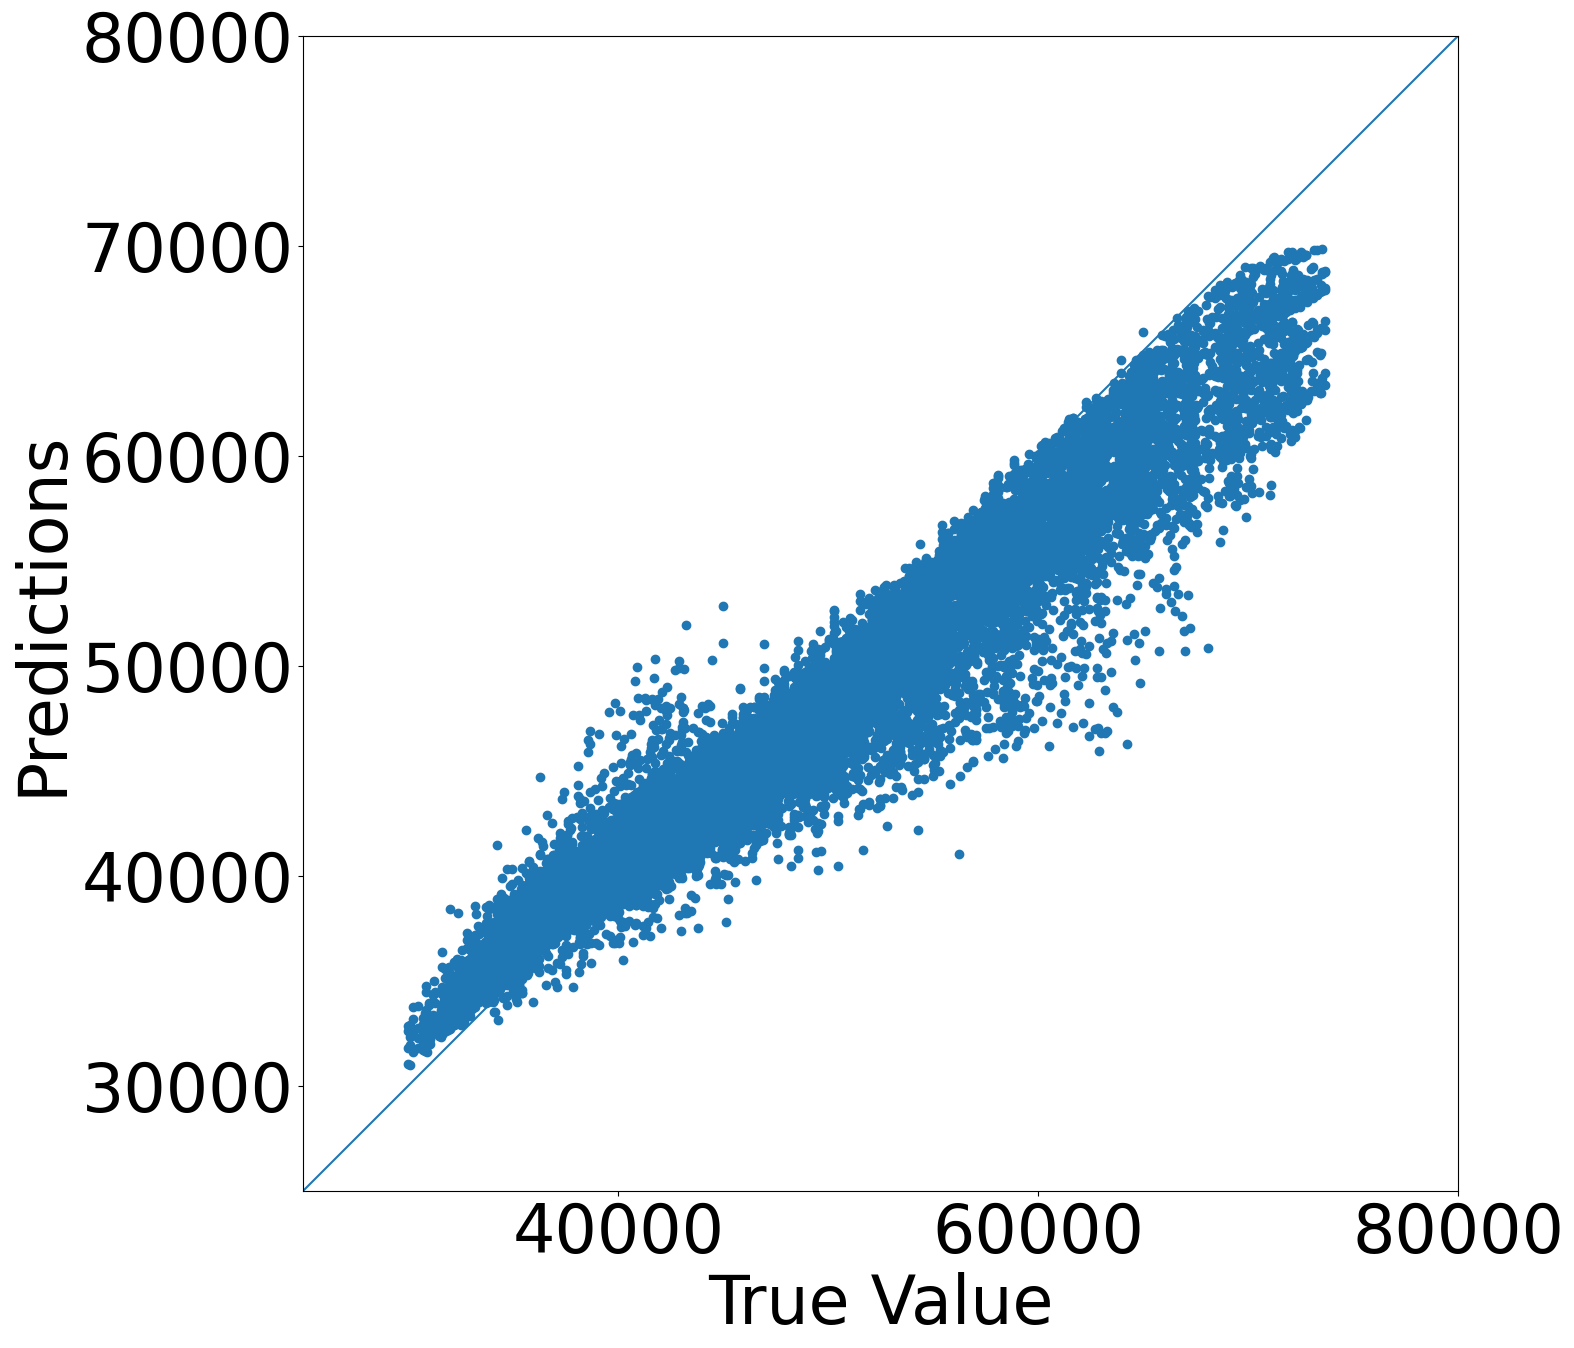

In [22]:
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual'], predictions)
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [25000, 80000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [23]:
end = datetime.datetime.now()
print('total time:', end-start)

total time: 0:02:53.576190


In [24]:
from keras.models import save_model
save_model(model,'Models/LSTM_model_0.0.h5',include_optimizer=True)
np.save('Models/LSTM_history_0.0.npy',history.history)